In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pyinterp import fill, Axis, TemporalAxis, Grid3D, Grid2D
import scipy.fftpack as fp
from scipy.interpolate import RegularGridInterpolator, griddata
from math import *

# 1. - Functions

In [3]:
def gaspari_cohn(array,distance,center):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. @vbellemin.
        
        Args: 
            array : array of value whose the Gaspari-Cohn function will be applied
            center : centered value of the function 
            distance : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [4]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

# 3. - Masking SF bay 

In [7]:
mask = xr.open_dataset("/bettik/bellemva/MITgcm/mask/mask.nc")
mask_bis = mask.mask.values
mask_bis[:,1320:1350,2760:2780]=np.nan

(1300.0, 1350.0)

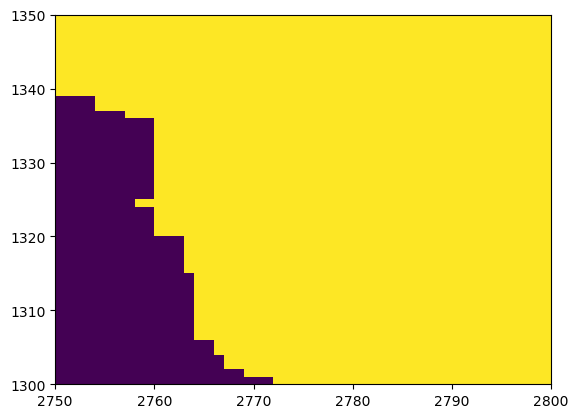

In [10]:
plt.pcolormesh(mask_bis[2])
plt.xlim(2750,2800)
plt.ylim(1300,1350)


In [12]:
np.save(file="/bettik/bellemva/MITgcm/mask/mask_MITgcm_nobay.npy",arr=mask_bis)

# 2. - Import 

In [6]:
test = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120605.nc")

In [7]:
ssh_hf = test.ssh_hf.where(np.invert(mask_bis),np.nan) # SSH HF with masked SF bay 

In [8]:
ds_deg = ssh_hf.coarsen(longitude=4,latitude=4,boundary='trim').mean()

In [9]:
ds_deg

<xarray.DataArray 'ssh_hf' (time: 24, latitude: 420, longitude: 780)>
array([[[-0.71819575, -0.70576125, -0.70317499, ...,  0.92102251,
          0.90693742,  0.90106352],
        [-0.71195378, -0.7065617 , -0.70871779, ...,  0.91479214,
          0.91654804,  0.91589334],
        [-0.70836306, -0.71635158, -0.71386122, ...,  0.9201555 ,
          0.91858558,  0.92381543],
        ...,
        [ 0.0966878 ,  0.09706831,  0.10481579, ...,         nan,
                 nan,         nan],
        [ 0.10129865,  0.10162659,  0.10456247, ...,         nan,
                 nan,         nan],
        [ 0.10531299,  0.10365926,  0.10068893, ...,         nan,
                 nan,         nan]],

       [[-0.33924985, -0.32577566, -0.2906275 , ...,  1.13633149,
          1.12534008,  1.12267218],
        [-0.34723734, -0.33780987, -0.3109    , ...,  1.12545657,
          1.11526885,  1.1330857 ],
        [-0.32551315, -0.31958103, -0.33207969, ...,  1.13451043,
          1.12704435,  1.13978455],
...
        [-0.05830095, -0.05354662, -0.056766  , ...,         nan,
                 nan,         nan],
        [-0.05744241, -0.05796793, -0.05834726, ...,         nan,
                 nan,         nan],
        [-0.06619412, -0.06469497, -0.06144399, ...,         nan,
                 nan,         nan]],

       [[-0.87143052, -0.8794626 , -0.8951073 , ...,  0.17706621,
          0.16699695,  0.14820533],
        [-0.88665877, -0.89206942, -0.90690267, ...,  0.16574348,
          0.16828135,  0.15315638],
        [-0.90431599, -0.90939252, -0.91226636, ...,  0.17985061,
          0.16745382,  0.15650218],
        ...,
        [ 0.12112786,  0.12191816,  0.12515675, ...,         nan,
                 nan,         nan],
        [ 0.12698978,  0.12728037,  0.12629538, ...,         nan,
                 nan,         nan],
        [ 0.12668105,  0.12368143,  0.1209736 , ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2012-06-05 ... 2012-06-05T23:00:00
  * latitude   (latitude) float32 10.03 10.11 10.2 10.28 ... 44.78 44.86 44.95
  * longitude  (longitude) float32 180.0 180.1 180.2 180.3 ... 244.8 244.9 244.9

# 3. - Interpolating on cartesian grid

In [10]:
x_axis = Axis(ds_deg.longitude.values,is_circle=True)
y_axis = Axis(ds_deg.latitude.values,is_circle=True)
t_axis = TemporalAxis(ds_deg.time.values)

grid = Grid3D(y_axis, x_axis, t_axis, ds_deg.values.transpose(1,2,0))
has_converged, filled = fill.gauss_seidel(grid,num_threads=4)

ds_filled = ds_deg.copy(deep=True,data=filled.transpose(2,0,1))


In [12]:
# GEODESIC GRID DEFINITION # 
latitude = ds_deg.latitude.values 
longitude = ds_deg.longitude.values 
lon2d,lat2d = np.meshgrid(longitude,latitude)

dx=10 # GRID SPACING IN KM
km2deg = 1./111


In [13]:
# ENSEMBLE OF LATITUDES # 
ENSLAT = np.arange(latitude[0],latitude[-1],dx*km2deg)
range_lon = longitude[-1]-longitude[0]
nstep_lon = floor(range_lon/(dx*km2deg))
ENSLAT2D = np.repeat(np.expand_dims(np.arange(latitude[0],latitude[-1],dx*km2deg),axis=1),axis=1,repeats=nstep_lon)

# ENSEMBLE OF LATITUDES # 
mid_lon = (longitude[-1]+longitude[0])/2
ENSLON2D=np.zeros_like(ENSLAT2D)

for i in range(len(ENSLAT)):
    d_lon = dx*km2deg*(np.cos(np.pi*latitude[0]/180)/np.cos(np.pi*latitude[i]/180))
    d_lon_range = np.array([i*d_lon for i in range (1,int(nstep_lon/2)+1)])
    lon_left = np.flip(mid_lon-d_lon_range)
    lon_right = mid_lon+d_lon_range
    ENSLON2D[i,:]=np.concatenate((lon_left,lon_right))
    

In [14]:
# TEST OF INTERPOLATION WITH XARRAY #
ds_interp = ds_filled.interp(latitude=('z',ENSLAT2D.flatten()),
                 longitude=('z',ENSLON2D.flatten())
                 )

In [15]:
ds_interp.set_index(z=("latitude","longitude"))

<xarray.DataArray 'ssh_hf' (time: 24, z: 279360)>
array([[-0.71432922, -0.70474736, -0.69642993, ...,         nan,
                nan,         nan],
       [-0.33506003, -0.31199663, -0.29171227, ...,         nan,
                nan,         nan],
       [ 0.13274677,  0.12702026,  0.12330379, ...,         nan,
                nan,         nan],
       ...,
       [-0.33415841, -0.32615665, -0.33310176, ...,         nan,
                nan,         nan],
       [-0.70106936, -0.70600204, -0.69934813, ...,         nan,
                nan,         nan],
       [-0.87392811, -0.88559575, -0.89289585, ...,         nan,
                nan,         nan]])
Coordinates:
  * time       (time) datetime64[ns] 2012-06-05 ... 2012-06-05T23:00:00
  * z          (z) object MultiIndex
  * latitude   (z) float64 10.03 10.03 10.03 10.03 10.03 ... 44.9 44.9 44.9 44.9
  * longitude  (z) float64 180.1 180.1 180.2 180.3 ... 255.3 255.4 255.5 255.7

In [18]:
ENSLAT2D.shape

(388, 720)

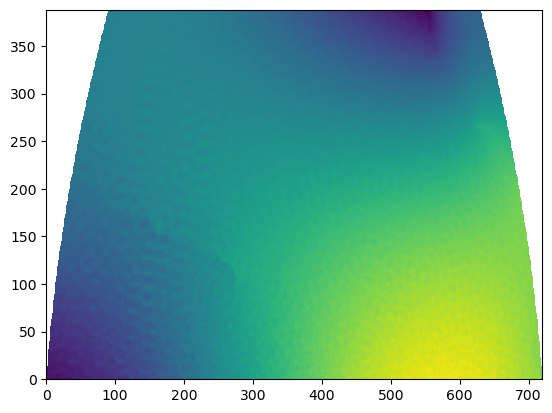

In [19]:
plt.pcolormesh(ds_interp[0].values.reshape(ENSLAT2D.shape))

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,10),dpi=200)
plt.scatter(lon2d[::15,::15],lat2d[::15,::15],s=2,label="GEODESIC GRID")
plt.scatter(ENSLON2D[::15,::15],ENSLAT2D[::15,::15],s=2,c='red',label="CARTESIAN GRID")
ax.legend(loc = 4)
ax.set_xlabel("Longitude",fontsize=18)
ax.set_ylabel("Latitude",fontsize=18)
ax.set_xlim(168,262)
ax.set_title("Transformation from Geodesic Grid to Cartesian Grid",fontsize=24)
ax.set_aspect("equal")

In [ ]:
# INTERPOLATING SSH # 
lon2d,lat2d = np.meshgrid(longitude,latitude)
ssh_cart = griddata(np.array([lat2d.flatten(),lon2d.flatten()]).T, filled.T.flatten(), (ENSLAT2D,ENSLON2D), method='cubic')

mask_cart = np.isnan(ssh_cart)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,10),dpi=200)
ax.pcolormesh(10*np.arange(ssh_cart.shape[1]),10*np.arange(ssh_cart.shape[0]),ssh_cart)
ax.set_xlabel("X [km]",fontsize=18)
ax.set_ylabel("Y [km]",fontsize=18)
ax.set_title("SSH over Cartesian Grid",fontsize=24)
ax.set_aspect("equal")


In [ ]:
x_axis = Axis(np.arange(ssh_cart.shape[0]))
y_axis = Axis(np.arange(ssh_cart.shape[1]))

grid = Grid2D(x_axis, y_axis,ssh_cart)
has_converged, filled_cartesian = fill.gauss_seidel(grid)


In [ ]:
plt.pcolormesh(filled_cartesian)

# 4. - Extracting bar tide 

In [ ]:
def lonlat2dxdy(lon,lat):
    dlon = np.gradient(lon)
    dlat = np.gradient(lat)
    dx = np.sqrt((dlon[1]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[1]*111000)**2)
    dy = np.sqrt((dlon[0]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[0]*111000)**2)
    dx[0,:] = dx[1,:]
    dx[-1,: ]= dx[-2,:] 
    dx[:,0] = dx[:,1]
    dx[:,-1] = dx[:,-2]
    dy[0,:] = dy[1,:]
    dy[-1,:] = dy[-2,:] 
    dy[:,0] = dy[:,1]
    dy[:,-1] = dy[:,-2]
    return dx,dy

In [ ]:
def lowpass(_lambda,nx,ny,wavenum2D) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]<1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

In [ ]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [ ]:
ssh0 = filled_cartesian

nx = ssh_cart.shape[1]
ny = ssh_cart.shape[0]

kx = np.fft.fftfreq(3*nx,dx) # km
ky = np.fft.fftfreq(3*ny,dx) # km
k, l = np.meshgrid(kx,ky)
wavenum2D = np.sqrt(k**2 + l**2)

lambda_bar = 400
lowpass_bar = lowpass(lambda_bar,nx,ny,wavenum2D)

window = create_spatial_window(nx,ny)

ssh = extend(ssh0,nx,ny)
ssh = ssh * window
ssh_freq = fp.fft2(ssh)
ssh_freq_filtered = lowpass_bar * ssh_freq
ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))[ny:2*ny,nx:2*nx]

#ssh_filtered[mask_cart]=np.nan


In [ ]:
points = np.array([ENSLAT2D.flatten(),ENSLON2D.flatten()]).T
values = ssh_filtered.flatten()
grid = (latitude,longitude)
lon2d,lat2d = np.meshgrid(longitude,latitude)

#filtered_geo = griddata(points, values, (lat2d,lon2d), method='cubic')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=200)
ax.pcolormesh(filtered_geo,vmin=-1,vmax=1,cmap="RdBu")
ax.set_aspect("equal")

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=200)
ax.pcolormesh(ds_deg-filtered_geo,vmin=-0.1,vmax=0.1,cmap="RdBu")
ax.set_aspect("equal")

# 4. - Downgrading signal 

In [ ]:
test = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120605.nc")

In [ ]:
ssh_hf = test.ssh_hf.where(np.invert(mask_bis),np.nan) # SSH HF with masked SF bay

In [ ]:
from datetime import datetime

In [ ]:
coarsen = ssh_hf.coarsen(longitude=4,latitude=4,boundary='trim').mean()

In [ ]:
rolling

In [ ]:
plt.pcolormesh(coarsen.values)

In [ ]:
rolling

In [ ]:
time0 = datetime.now()
rolling = ssh_hf.rolling({'longitude':5,'latitude':5},center=True,min_periods=1).mean()[::4,::4]
print(datetime.now()-time0)

In [ ]:
time0 = datetime.now()
for i in range (24):
    rolling = ssh_hf[i].rolling({'longitude':5,'latitude':5},center=True,min_periods=1).mean()[::4,::4]
print(datetime.now()-time0)

In [ ]:
time0 = datetime.now()
rolling = ssh_hf.rolling({'longitude':5,'latitude':5},center=True,min_periods=1).mean()
ds_deg = rolling.interp({'longitude':np.round(np.arange(180.0,245.0+1/13,1/12),decimals=10),'latitude':np.round(np.arange(10.0,45.0+1/13,1/12),decimals=10)})
print(datetime.now()-time0)

In [ ]:
rolling

In [ ]:
rolling = ssh_hf.rolling({'longitude':5,'latitude':5},center=True,min_periods=1).mean()
ds_deg = rolling.interp({'longitude':np.round(np.arange(180.0,245.0+1/13,1/12),decimals=10),'latitude':np.round(np.arange(10.0,45.0+1/13,1/12),decimals=10)})
ds_deg

In [ ]:
### GAUSSIAN KERNEL BUILT WITH PASCAL TRIANGLE ### 
array = np.array([[1,8,28,56,70,56,28,8,1]]) # 9 item Pascal Triangle 
gaussian_kernel = (1/array.sum()**2)*array.T*array

### PADDED SSH FIELD FOR AVOIDING PROBLEMS AT FRONTIER ### 
ssh_hf_pad = np.nan*np.ones((ssh_hf.shape[0]+8,ssh_hf.shape[1]+8))
ssh_hf_pad[4:ssh_hf.shape[0]+4,4:ssh_hf.shape[1]+4]=ssh_hf

In [ ]:
ssh_deg = np.nan*np.ones((ssh_hf.shape[0]//4+1,ssh_hf.shape[1]//4+1),dtype='float64')
for i in range (0,ssh_hf.shape[1],4):
    for j in range (0,ssh_hf.shape[0],4):
        #if not np.isnan(ssh_hf_pad[j:j+9,i:i+9]).all():
        #ssh_pattern = np.nan_to_num(ssh_hf_pad[j:j+9,i:i+9],copy=True)
        ssh_deg[j//4,i//4]=np.nanmean(ssh_hf_pad[j:j+9,i:i+9]*gaussian_kernel)